In [1]:
from copy import deepcopy
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle
import pprint
import scipy.optimize as opt

from qiskit import pulse, transpile, assemble, schedule, IBMQ, quantum_info as qi
from qiskit.pulse.library import gaussian_square
from qiskit.pulse.transforms import align_measures
from qiskit.ignis.verification import randomized_benchmarking as rb

import qiskit

# utility for pulse schedule generation
from utils.cr_pulse_utils import create_cr_circuit, var_amp, var_phi

# utility for quantum process tomography
from utils.qpt_utils import create_qpt_experiment, extract_choi_matrix

# utility for randomized benchmarking
from utils.rb_utils import create_rb_experiment, cache_circuit

# utility for analysis
from utils.analysis_utils import (cr_3rd_order_perturbation, local_fidelity_optimization, 
                                  optimize_circuit, expectation_val, hamiltonian_reconstruction,
                                  plot_quantum_channel, ExperimentRunner)

# Demonstration of a Cross-Resonance Entangling Gate
Author: Naoki Kanazawa

Source code for paper [Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses - Thomas Alexander et al 2020 Quantum Sci. Technol. 5 044006](https://doi.org/10.1088/2058-9565/aba404)

### Release Notes

#### Version 2.0(this)

- A bug has been fixed where qubits were being measured into the wrong location. In the previous version, the notebook worked only with qubits `[1, 0]` and otherwise it failed. 
- The code has been slightly updated based on Qiskit `0.23.4`, mainly for addressing deprecated imports. 
- `ibmq_almaden` was used in the original experiment, however, it is no longer available at the time of this update. This version of the notebook uses `ibmq_montreal`. Therefore, the device parameters, data and results are different from the original paper's source which may be found [here](https://zenodo.org/record/3653502).

#### [Version 1.0](https://zenodo.org/record/3653502)

- The original experimental result results for the target paper using the now deprecated `ibmq_almaden`. Tested with Qiskit 0.18.0. The experimental data is cached at `/data/custom_cnot_experiments/ibmq_almaden`.

## Configuration

In [2]:
# use cache data
use_cache = True

# data data_directory
data_dir = './data/custom_cnot_experiments/ibmq_montreal'

### IBM Quantum

To run experiments an IBM system credentials must [first be loaded]([https://github.com/Qiskit/qiskit-terra#executing-your-code-on-a-real-quantum-chip) and then a `hub`, `group` and `project` with access to a Qiskit pulse enabled device must be selected. For more help see the [Qiskit documentation](https://qiskit.org/documentation/).

In [3]:
account_provider = IBMQ.load_account()
hub = 'hub'
group = 'group'
project = 'project'

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [4]:
# target backend
backend_name = 'ibmq_montreal'

In [5]:
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend(backend_name)

In [6]:
########################
#                      #
# Setup of experiments #
#                      #
########################

# control qubit index
control = 11

# target qubit index
target = 8

# maximum cross resonance amplitude in this experiment
max_cr_amplitude = 0.35

# sample number restriction
alignment = 16

# initial cross resonance pulse parameters
cr_params = {'duration': 60 * alignment, 'amp': var_amp, 'phi': var_phi,
             'sigma': 2 * alignment, 'risefall': 4 * alignment}

In [7]:
# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# sorted list of qubits used in the experiments
cr_qubits = sorted([control, target])

# quantum registers for handling abstracted schedule
qregs = qiskit.QuantumRegister(config.n_qubits)

In [8]:
# control channel index
u_index = config.control((control, target))[0].index

# channels for visualization
channels = [pulse.DriveChannel(control), pulse.DriveChannel(target), pulse.ControlChannel(u_index)]

# index of memory slot at which the measurement data of target qubit is stored
mem_ind = 0 if control > target else 1

Experiment manager

In [9]:
runner = ExperimentRunner(path=data_dir, backend=backend, cached=use_cache)

# 1. Calibration of CR phase

Setup

In [10]:
shots = 1024

In [11]:
# create QuantumCircuit layer abstraction of CR pulse schedule.
# this technique is useful to incorporate pulse schedule with circuit instruction to
# program complicated calibration sequence while keeping context of operation.
cr_cal_circ, ext_inst_map, ext_basis_gates = create_cr_circuit(
    cross_resonance_params=cr_params,
    control=control,
    target=target,
    u_index=u_index,
    q_regs=qregs,
    inst_map=defaults.instruction_schedule_map,
    basis_gates=config.basis_gates,
    use_echo=True)

cr_cal_circ.draw(fold=-1, idle_wires=False)

┌────────────────┐     ┌────────────────┐     
 q0_8: ┤1               ├─────┤1               ├─────
       │  zx_p(amp,phi) │┌───┐│  zx_m(amp,phi) │┌───┐
q0_11: ┤0               ├┤ X ├┤0               ├┤ X ├
       └────────────────┘└───┘└────────────────┘└───┘

## 1-1. Rough amplitude calibration

In [12]:
cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, 20)

# setup CR Rabi experiment with Z measurement
cr_rabi_circ = cr_cal_circ.copy()
cr_rabi_circ.measure_active()

cr_rabi_circs = []
for cind, cr_amp in enumerate(cr_amps):
    fixed_cr_circ = cr_rabi_circ.bind_parameters({var_amp: cr_amp, var_phi: 0})
    fixed_cr_circ.name = 'cr_rabi_circ_%d' % cind
    cr_rabi_circs.append(fixed_cr_circ)

transpiled_circuits = transpile(cr_rabi_circs, backend, basis_gates=ext_basis_gates, optimization_level=0)
scheds = schedule(transpiled_circuits, backend, inst_map=ext_inst_map)

qobj_1_1 = assemble(scheds, backend, meas_level=2, shots=shots)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [13]:
# run experiment
result_1_1 = runner.run(qobj_1_1, '1-1_amp_cal')

Analysis

In [14]:
def cr_fit_3rd_order_perturbation(x, c1, c2):
    fx = c1*x - c2*x**3
    return np.cos(2 * np.pi * fx)

def rough_amp_objective(x, params, opt_phase):
    fx = params[0] * x - params[1] * x**3
    return np.abs(opt_phase / 2 / np.pi - fx)

In [15]:
exp_z = np.zeros_like(cr_amps)
for cind in range(len(cr_amps)):
    exp_z[cind] = expectation_val(result_1_1, mem_ind=mem_ind, exp_name='cr_rabi_circ_%d' % cind)

valid_inds = np.where(np.abs(cr_amps) < 0.35)[0]
params, _ = opt.curve_fit(cr_fit_3rd_order_perturbation, xdata=cr_amps[valid_inds], ydata=exp_z[valid_inds])
cr_pi2_amp = opt.minimize(rough_amp_objective, x0=0, bounds=[(0, 1)], args=(params, 0.5 * np.pi)).x[0]

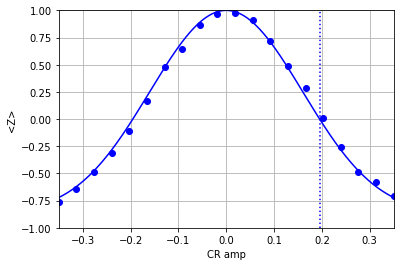

In [16]:
x_interp = np.linspace(cr_amps[0], cr_amps[-1], 1000)
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.plot(x_interp, cr_fit_3rd_order_perturbation(x_interp, *params), color='b')
plt.plot([cr_pi2_amp, cr_pi2_amp], [-1, 1], 'b:')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)
plt.xlabel('CR amp')
plt.ylabel('<Z>')
plt.grid()

In [17]:
cr_pi2_amp

0.19530490355496566

## 1-2. Phase calibration

In [18]:
cr_phases = np.linspace(-np.pi, np.pi, 20)

# setup phase sweep experiment with Y measurement under control state = |0>
cr_phase_circ0 = qiskit.QuantumCircuit(qregs)
cr_phase_circ0 += cr_cal_circ
cr_phase_circ0.barrier(qregs[control], qregs[target])
cr_phase_circ0.sdg(qregs[target])
cr_phase_circ0.h(qregs[target])
cr_phase_circ0.measure_active()

# setup phase sweep experiment with Y measurement under control state = |1>
cr_phase_circ1 = qiskit.QuantumCircuit(qregs)
cr_phase_circ1.x(qregs[control])
cr_phase_circ1 += cr_cal_circ
cr_phase_circ1.barrier(qregs[control], qregs[target])
cr_phase_circ1.sdg(qregs[target])
cr_phase_circ1.h(qregs[target])
cr_phase_circ1.measure_active()

cr_phase_circs = []
for cind, cr_phase in enumerate(cr_phases):
    # control state = 0
    fixed_cr_circ0 = cr_phase_circ0.bind_parameters({var_amp: cr_pi2_amp, var_phi: cr_phase})
    fixed_cr_circ0.name = 'phase_swp_%d_0' % cind
    cr_phase_circs.append(fixed_cr_circ0)
    # control state = 1
    fixed_cr_circ1 = cr_phase_circ1.bind_parameters({var_amp: cr_pi2_amp, var_phi: cr_phase})
    fixed_cr_circ1.name = 'phase_swp_%d_1' % cind
    cr_phase_circs.append(fixed_cr_circ1)

transpiled_circuits = transpile(cr_phase_circs, backend, basis_gates=ext_basis_gates, optimization_level=0)
scheds = schedule(transpiled_circuits, backend, inst_map=ext_inst_map)

qobj_1_2 = assemble(scheds, backend, meas_level=2, shots=shots)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [19]:
# run experiment
result_1_2 = runner.run(qobj_1_2, '1-2_phi_cal')

Analysis

In [20]:
def cos_fit_00(x, a, b):
    return a * np.cos(x - b + np.pi)

def cos_fit_10(x, a, b):
    return a * np.cos(x - b)

In [21]:
exp_y0 = np.zeros_like(cr_phases)
exp_y1 = np.zeros_like(cr_phases)

for cind in range(len(cr_phases)):
    exp_y0[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_0' % cind)
    exp_y1[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_1' % cind)

params0, _ = opt.curve_fit(cos_fit_00, xdata=cr_phases, ydata=exp_y0, bounds=([0, -np.pi], [1, np.pi]))
params1, _ = opt.curve_fit(cos_fit_10, xdata=cr_phases, ydata=exp_y1, bounds=([0, -np.pi], [1, np.pi]))

phi_opt = (params0[1] + params1[1]) / 2

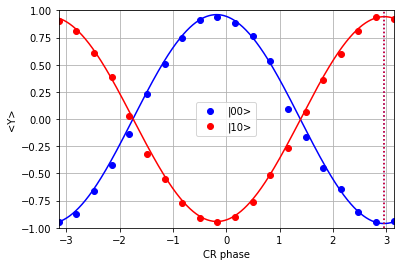

In [22]:
x_interp = np.linspace(cr_phases[0], cr_phases[-1], 1000)
plt.plot(cr_phases, exp_y0, 'o', color='b', label='|00>')
plt.plot(cr_phases, exp_y1, 'o', color='r', label='|10>')
plt.plot(x_interp, cos_fit_00(x_interp, *params0), 'b')
plt.plot(x_interp, cos_fit_10(x_interp, *params1), 'r')
plt.plot([params0[1], params0[1]], [-1, 1], 'b:')
plt.plot([params1[1], params1[1]], [-1, 1], 'r:')
plt.xlim(cr_phases[0], cr_phases[-1])
plt.ylim(-1, 1)
plt.xlabel('CR phase')
plt.ylabel('<Y>')
plt.grid()
plt.legend()

In [23]:
phi_opt

2.9635627303797842

In [24]:
# fix CR phase
cr_params['phi'] = phi_opt

# 2. Amplitude sweep process tomography

Setup

In [25]:
shots = 2048

# cross resonance amplitudes to measure process tomography
cr_amplitudes = np.linspace(0, max_cr_amplitude, 6)

## 2-1. CR1 circuit

In [26]:
# create new QuantumCircuit layer abstraction of CR1 pulse schedule.
# this technique is necessary to work with current Ignis QPT module.
cr1_circ, ext_inst_map_cr1, ext_basis_gates_cr1 = create_cr_circuit(
    cross_resonance_params=cr_params,
    control=control,
    target=target,
    u_index=u_index,
    q_regs=qregs,
    inst_map=defaults.instruction_schedule_map,
    basis_gates=config.basis_gates,
    use_echo=False)

cr1_circ.draw(fold=-1, idle_wires=False)

┌────────────┐
 q0_8: ┤1           ├
       │  zx_p(amp) │
q0_11: ┤0           ├
       └────────────┘

In [27]:
# setup CR amplitude sweep for QPT
qpt_cr1_circs = []
for cr_amp in cr_amplitudes:
    fixed_cr_circ = cr1_circ.bind_parameters({var_amp: cr_amp})
    qpt_cr1_circs.append(fixed_cr_circ)

# create QPT experiments
qobj_2_1, qcs, meas_labels = create_qpt_experiment(
    target_circuits=qpt_cr1_circs,
    control=control,
    target=target,
    backend=backend,
    inst_map=ext_inst_map_cr1,
    basis_gate=ext_basis_gates_cr1,
    shots=shots)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [28]:
# run experiment
result_2_1 = runner.run(qobj_2_1, '2-1_cr1_qpts')

Analysis

In [29]:
cr1_chois = [choi for choi in extract_choi_matrix(result_2_1, qcs, meas_labels)]

if not use_cache:
    # output data for future analysis.
    np.save('%s/2-1_cr1_qpts_choi_mat.npy' % data_dir, [cr1_choi.data for cr1_choi in cr1_chois])

readout fidelity = 0.974


## 2-2. CR2 circuit

In [30]:
# create new QuantumCircuit layer abstraction of CR2 pulse schedule.
# this technique is necessary to work with current Ignis QPT module.
cr2_circ, ext_inst_map_cr2, ext_basis_gates_cr2 = create_cr_circuit(
    cross_resonance_params=cr_params,
    control=control,
    target=target,
    u_index=u_index,
    q_regs=qregs,
    inst_map=defaults.instruction_schedule_map,
    basis_gates=config.basis_gates,
    use_echo=True)

cr2_circ.draw(fold=-1, idle_wires=False)

┌────────────┐     ┌────────────┐     
 q0_8: ┤1           ├─────┤1           ├─────
       │  zx_p(amp) │┌───┐│  zx_m(amp) │┌───┐
q0_11: ┤0           ├┤ X ├┤0           ├┤ X ├
       └────────────┘└───┘└────────────┘└───┘

In [31]:
# setup CR amplitude sweep for QPT
qpt_cr2_circs = []
for cr_amp in cr_amplitudes:
    fixed_cr_circ = cr2_circ.bind_parameters({var_amp: cr_amp})
    qpt_cr2_circs.append(fixed_cr_circ)

# create QPT experiments
qobj_2_2, qcs, meas_labels = create_qpt_experiment(
    target_circuits=qpt_cr2_circs,
    control=control,
    target=target,
    backend=backend,
    inst_map=ext_inst_map_cr2,
    basis_gate=ext_basis_gates_cr2,
    shots=shots)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [32]:
# run experiment
result_2_2 = runner.run(qobj_2_2, '2-2_cr2_qpts')

Analysis

In [33]:
cr2_chois = [choi for choi in extract_choi_matrix(result_2_2, qcs, meas_labels)]

if not use_cache:
    # output data for future analysis.
    np.save('%s/2-2_cr2_qpts_choi_mat.npy' % data_dir, [cr2_choi.data for cr2_choi in cr2_chois])

readout fidelity = 0.973


# 3. Snapshot of system status

In [34]:
def average_amp(x):
    cr_pulse_temp = gaussian_square(duration=cr_params['duration'],
                                    amp=x,
                                    sigma=cr_params['sigma'],
                                    risefall=cr_params['risefall'])
    return np.sum(cr_pulse_temp.samples.real) / cr_params['duration']

In [35]:
import datetime

anharmonicity = [properties.qubit_property(qind)['anharmonicity'][0] for qind in range(config.n_qubits)]
experiment_date = datetime.datetime.fromisoformat(result_1_1.date) if isinstance(result_1_1.date, str) else result_1_1.date
properties_at_runtime = backend.properties(datetime=experiment_date)

# Note that u2 and u3 gates are no longer used in the recent IBM Quantum backends.
experiment_conditions = {
    'backend_update': properties_at_runtime.last_update_date,
    'backend_cnot_fidelity': 1 - properties_at_runtime.gate_error('cx', qubits=(control, target)),
    'backend_cnot_gate_length': properties_at_runtime.gate_length('cx', qubits=(control, target)),
    'control_gate_errors': {'u2': properties_at_runtime.gate_error('sx', qubits=control), 
                            'u3': 2. * properties_at_runtime.gate_error('sx', qubits=control)},
    'target_gate_errors': {'u2': properties_at_runtime.gate_error('sx', qubits=control), 
                           'u3': 2. * properties_at_runtime.gate_error('sx', qubits=control)},
    'control_qubit_freq': properties_at_runtime.frequency(control),
    'target_qubit_freq': properties_at_runtime.frequency(target),
    'control_qubit_anharmonicity': anharmonicity[control],
    'target_qubit_anharmonicity': anharmonicity[target],
    'delta': properties_at_runtime.frequency(control) - properties_at_runtime.frequency(target),
    'control_qubit_t1': properties_at_runtime.qubit_property(control)['T1'][0],
    'target_qubit_t1': properties_at_runtime.qubit_property(target)['T1'][0],
    'control_qubit_t2': properties_at_runtime.qubit_property(control)['T2'][0],
    'target_qubit_t2': properties_at_runtime.qubit_property(target)['T2'][0],    
    'cr_per_pulse_duration': cr_params['duration'] * config.dt,
    'cr_amplitudes': cr_amplitudes,
    'avg_amplitudes': [average_amp(amp) for amp in cr_amplitudes],
    'cr_params': {key: val if isinstance(val, (int, float)) else 'var' for key, val in cr_params.items()}
}

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Unless a UTC timezone information is present, the parameter `datetime`is now expected to be in local time instead of UTC.
  """


In [36]:
pprint.pprint(experiment_conditions)

{'avg_amplitudes': [0.0,
                    0.06570341228816094,
                    0.13140682457632188,
                    0.19711023686448287,
                    0.26281364915264377,
                    0.3285170614408048],
 'backend_cnot_fidelity': 0.9931802968095935,
 'backend_cnot_gate_length': 4.48e-07,
 'backend_update': datetime.datetime(2021, 2, 7, 20, 44, 8, tzinfo=tzlocal()),
 'control_gate_errors': {'u2': 0.00018062185360266943,
                         'u3': 0.00036124370720533886},
 'control_qubit_anharmonicity': -337450004.33273405,
 'control_qubit_freq': 5034143350.585283,
 'control_qubit_t1': 0.00011160416736275917,
 'control_qubit_t2': 4.835032032385238e-05,
 'cr_amplitudes': array([0.  , 0.07, 0.14, 0.21, 0.28, 0.35]),
 'cr_params': {'amp': 'var',
               'duration': 960,
               'phi': 2.9635627303797842,
               'risefall': 64,
               'sigma': 32},
 'cr_per_pulse_duration': 2.1333333333333334e-07,
 'delta': 125956590.22214222,
 'tar

# 4. Hamiltonian estimation

Setup:

Note that the first and second character in `puali_labels` will be swapped if the index of the control qubit is smaller than the target qubit.

In [37]:
cr_t = experiment_conditions['cr_per_pulse_duration']
delta = 2 * np.pi * experiment_conditions['delta']
alpha_c = 2 * np.pi * experiment_conditions['control_qubit_anharmonicity']
alpha_t = 2 * np.pi * experiment_conditions['target_qubit_anharmonicity']
pulse_avg_amplitude = experiment_conditions['avg_amplitudes']

pauli_labels = ['ZX', 'ZY', 'ZZ', 'ZI', 'IX', 'IY', 'IZ']
colors = ['b', 'g', 'r', 'orange', 'c', 'y', 'm']
markers = ['o', 'v', '^', 's', 'p', 'h', 'X']

In [38]:
fitters = {}
for pauli_label in pauli_labels:
    term_fitter = partial(cr_3rd_order_perturbation, delta=delta, alpha_c=alpha_c, alpha_t=alpha_t, pauli=pauli_label)
    fitters[pauli_label] = term_fitter

## 4-1. CR1 circuit

In [39]:
cr1_gate_time = cr_t

phase_guess = [0, 1, 5, 9, 20, 32]
shift_oper = 'ZI'

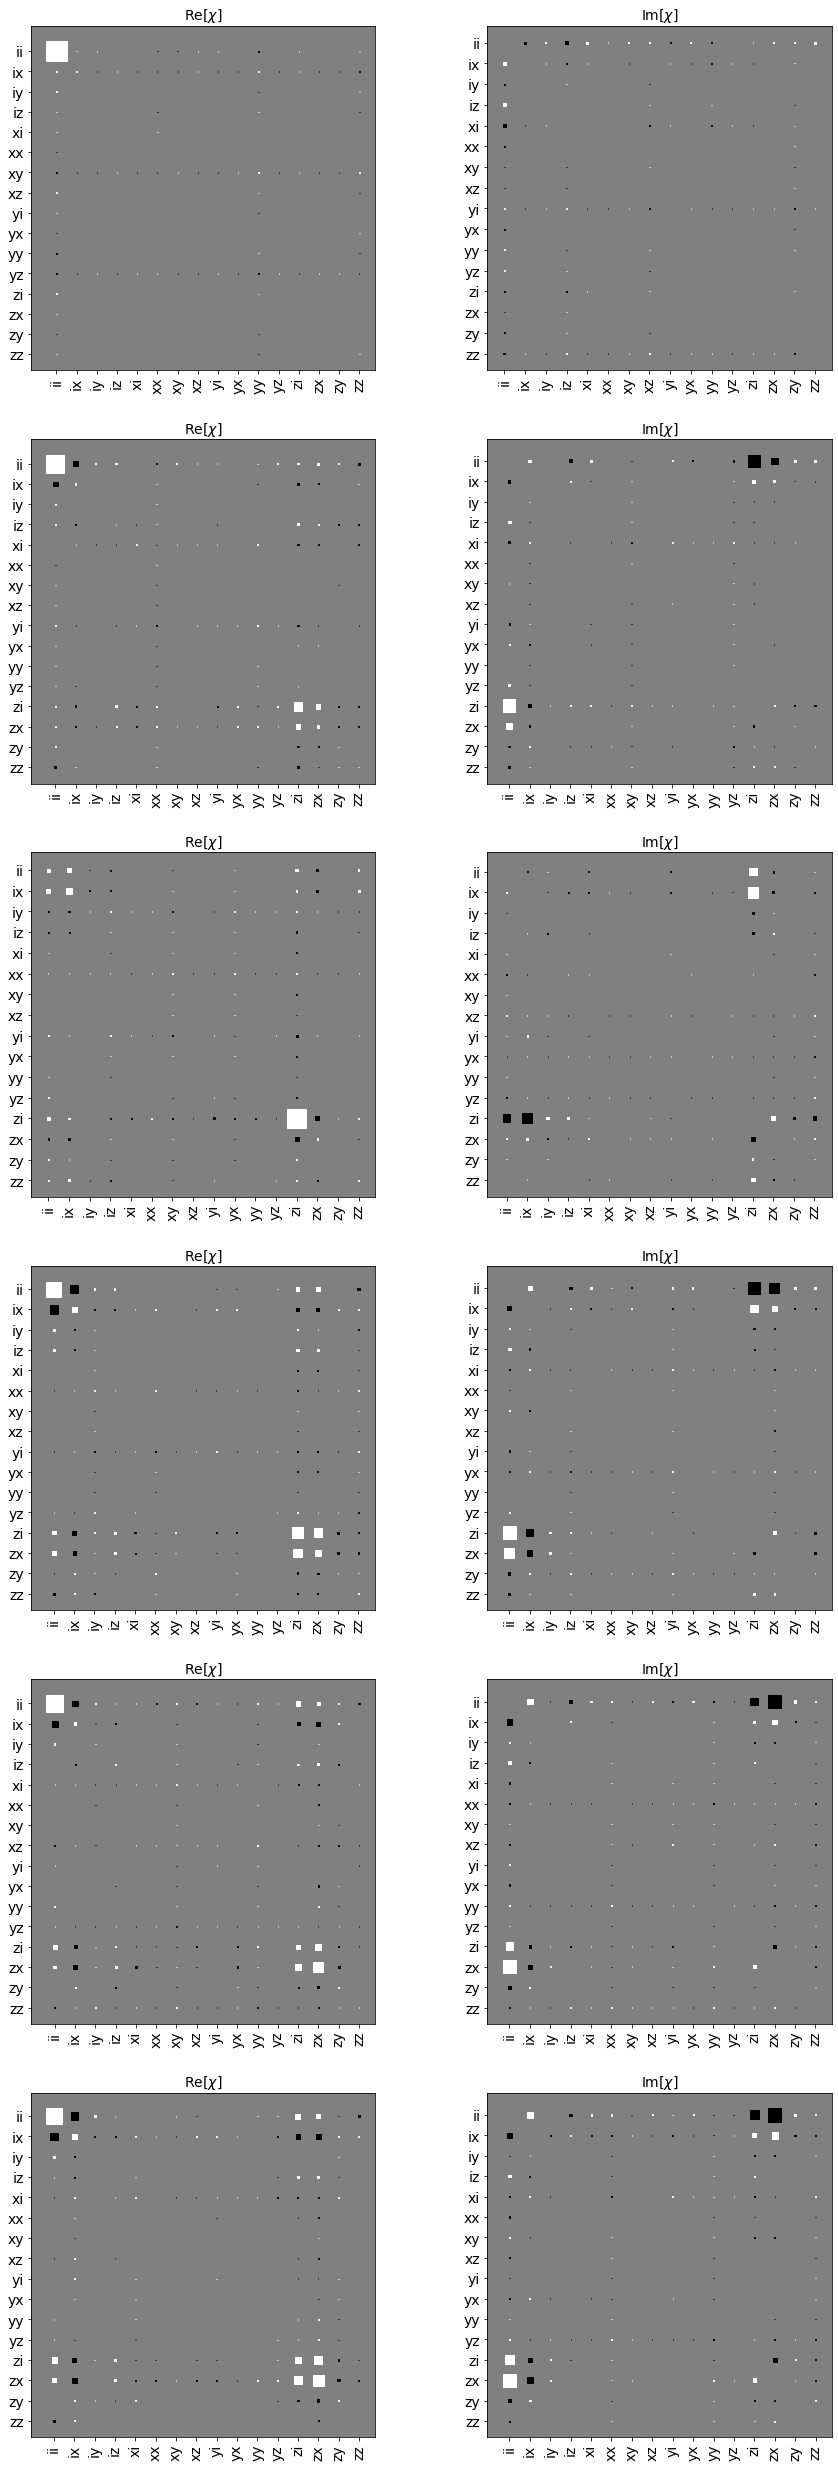

In [40]:
n_exp = len(cr1_chois)
plt.figure(figsize=(15, 15 * n_exp))
axs_r = [plt.subplot(2*n_exp, 2, 1 + 2*ii) for ii in range(n_exp)]
axs_i = [plt.subplot(2*n_exp, 2, 2 + 2*ii) for ii in range(n_exp)]
plot_quantum_channel(cr1_chois, axs_r, axs_i)
plt.show()

In [41]:
cr1_ham, fids = hamiltonian_reconstruction(cr1_chois, pauli_labels, cr1_gate_time, phase_guess, shift_oper)
print('F_avg between original Choi matrix and U of estimated Hamiltonian:\n%s\non average %s' % (fids, np.mean(fids)))

w_opt = -6.563e-08, cost_func = 4.517e-09, generator norm = 6.117e+00
Commutator [S, S_H] norm = 9.033e-09
w_opt = 9.761e-09, cost_func = 7.868e-10, generator norm = 3.717e+00
Commutator [S, S_H] norm = 1.557e-09
w_opt = 3.497e+00, cost_func = 5.496e-02, generator norm = -6.245e-08
Commutator [S, S_H] norm = 5.019e-02
w_opt = 7.773e+00, cost_func = 6.780e-02, generator norm = 4.243e-11
Commutator [S, S_H] norm = 1.355e-01
w_opt = 1.962e+01, cost_func = 7.429e-02, generator norm = -1.418e-10
Commutator [S, S_H] norm = 1.011e-01
w_opt = 3.200e+01, cost_func = 5.587e-02, generator norm = -2.795e-07
Commutator [S, S_H] norm = 6.025e-02
F_avg between original Choi matrix and U of estimated Hamiltonian:
[0.9980554612859747, 0.9955615132218384, 0.994602796468504, 0.9964444695115858, 0.9952211049466191, 0.9939752966562384]
on average 0.9956434403484601


In [42]:
j_guess = 1.0e6
c_guess = 200e6

cr1_params, conv = opt.curve_fit(fitters['ZX'], pulse_avg_amplitude, cr1_ham['ZX'], p0=[2*np.pi*j_guess, 2*np.pi*c_guess])
stdev = np.sqrt(np.diag(conv))[0]/2/np.pi/1e6

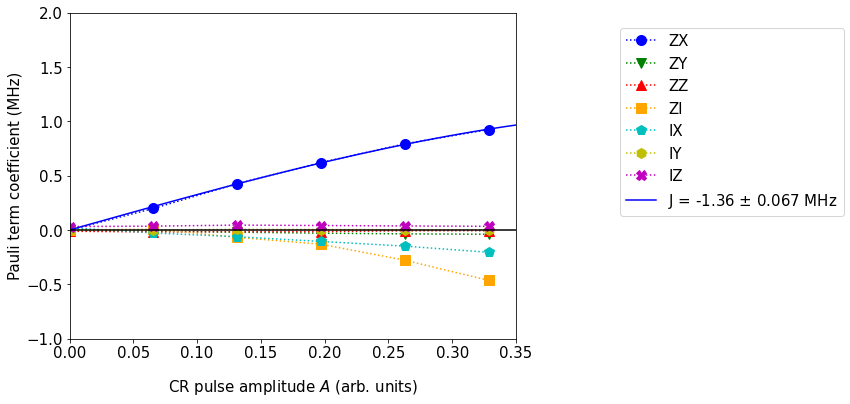

In [43]:
x_interp = np.linspace(0, 1, 100)
zi_scale = 0.01

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

for pauli_label, color, marker in zip(pauli_labels, colors, markers):
    if pauli_label == 'ZI':
        ax1.plot(pulse_avg_amplitude, zi_scale * cr1_ham[pauli_label]/2/np.pi/1e6,
                 '%s:' % marker, ms=10, color=color, label=pauli_label)
    else:
        ax1.plot(pulse_avg_amplitude, cr1_ham[pauli_label]/2/np.pi/1e6,
                 '%s:' % marker, ms=10, color=color, label=pauli_label)

# fit models
ax1.plot(x_interp, fitters['ZX'](x_interp, *cr1_params)/2/np.pi/1e6,
         color='b', label='J = %.2f $\pm$ %.3f MHz' % (cr1_params[0] / 2 / np.pi / 1e6, stdev))

ax1.plot([0, 1], [0, 0], 'k-')
ax1.set_xlabel(r'CR pulse amplitude $A$ (arb. units)', fontsize=15)
ax1.set_ylabel(r'Pauli term coefficient (MHz)', fontsize=15)
ax1.set_xlim(0, max_cr_amplitude)
ax1.set_ylim(-1, 2)
ax1.tick_params(labelsize=15)

ax1.xaxis.set_label_coords(0.5, -0.12)

ax1.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=1, fontsize=15)

## 4-2. CR-2 Circuit

In [44]:
cr2_gate_time = 2 * cr_t

phase_guess = [0, 0, 0, 0, -1, -1]
shift_oper = 'ZX'

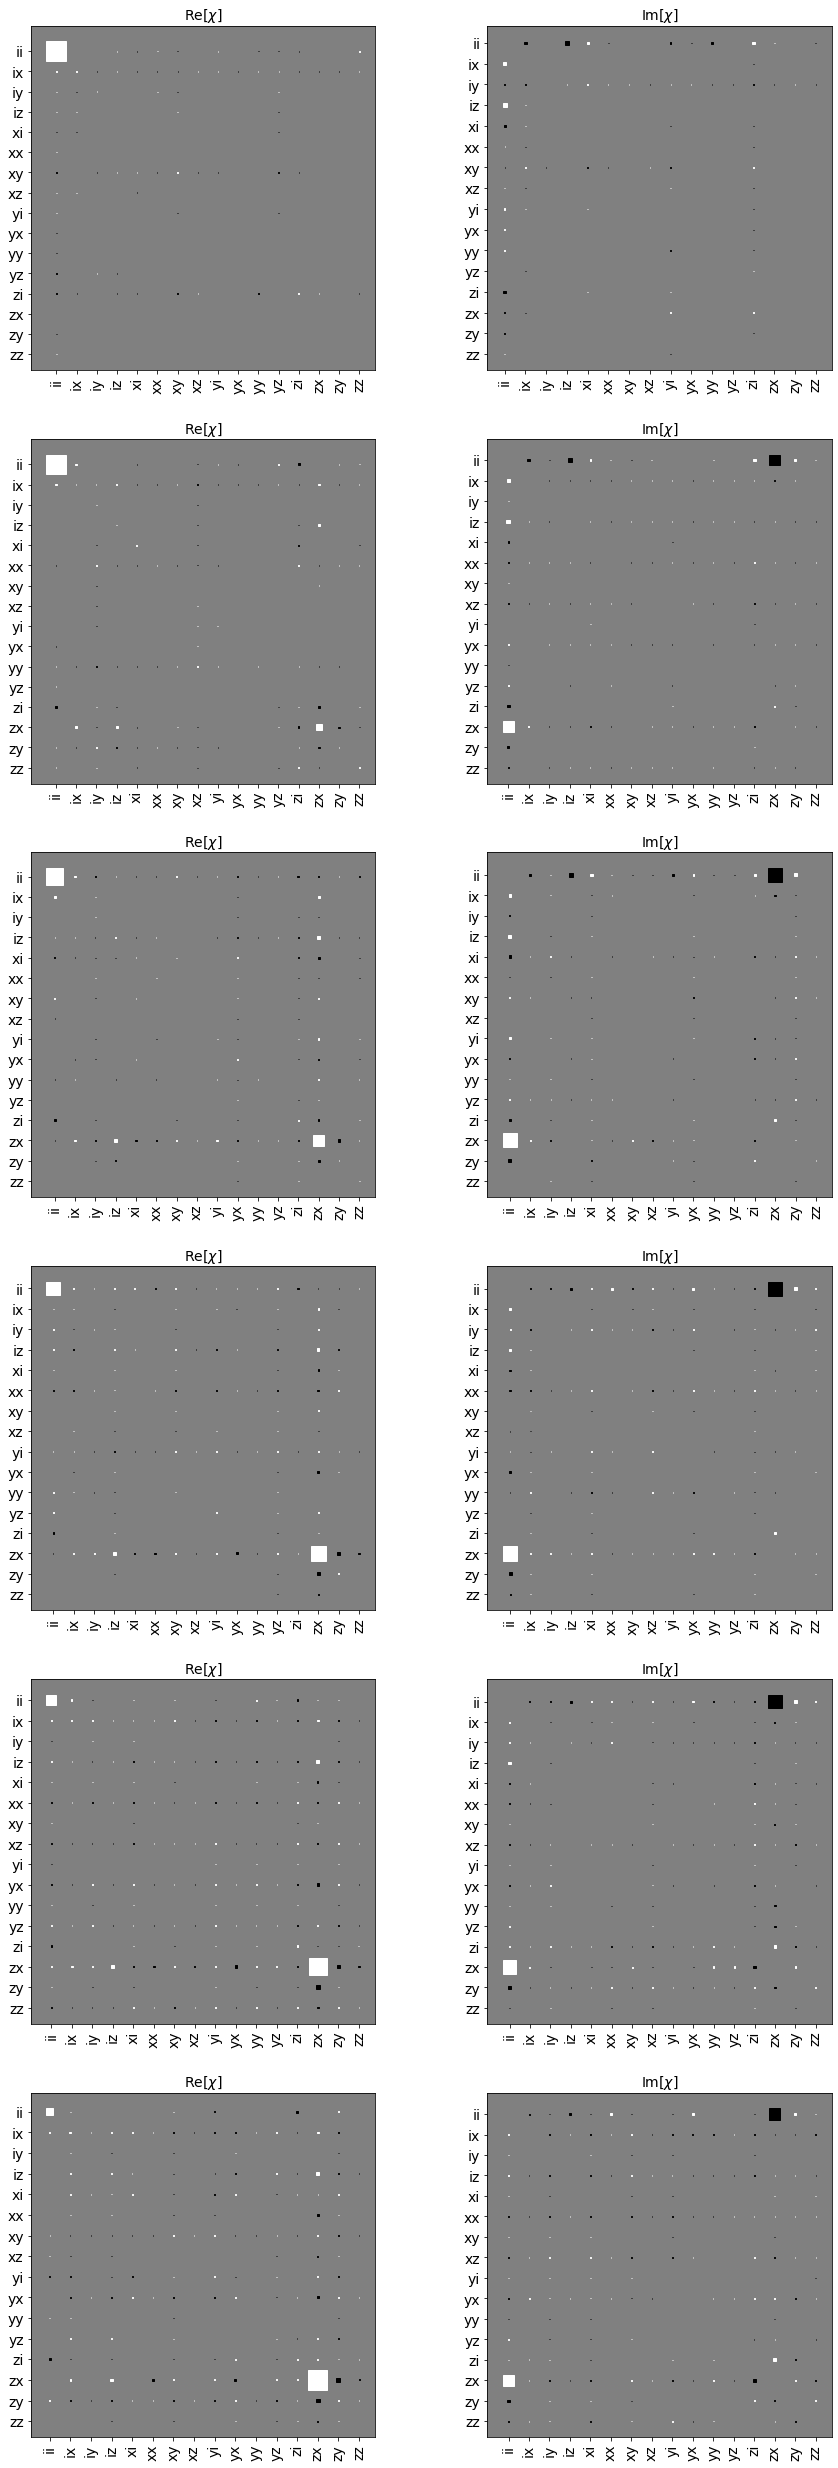

In [45]:
n_exp = len(cr2_chois)
plt.figure(figsize=(15, 15 * n_exp))
axs_r = [plt.subplot(2*n_exp, 2, 1 + 2*ii) for ii in range(n_exp)]
axs_i = [plt.subplot(2*n_exp, 2, 2 + 2*ii) for ii in range(n_exp)]
plot_quantum_channel(cr2_chois, axs_r, axs_i)
plt.show()

In [46]:
cr2_ham, fids = hamiltonian_reconstruction(cr2_chois, pauli_labels, cr2_gate_time, phase_guess, shift_oper)
print('F_avg between original Choi matrix and U of estimated Hamiltonian:\n%s\non average %s' % (fids, np.mean(fids)))

w_opt = -1.755e-07, cost_func = 3.232e-08, generator norm = 6.062e+00
Commutator [S, S_H] norm = 6.463e-08
w_opt = -1.969e-07, cost_func = 4.036e-08, generator norm = 4.604e+00
Commutator [S, S_H] norm = 8.031e-08
w_opt = -2.518e-07, cost_func = 6.511e-08, generator norm = 2.997e+00
Commutator [S, S_H] norm = 1.277e-07
w_opt = -2.323e-07, cost_func = 5.500e-08, generator norm = 1.647e+00
Commutator [S, S_H] norm = 1.057e-07
w_opt = 2.571e-07, cost_func = 7.194e-08, generator norm = 3.160e-01
Commutator [S, S_H] norm = 1.342e-07
w_opt = -1.290e-01, cost_func = 3.608e-02, generator norm = -8.538e-08
Commutator [S, S_H] norm = 6.764e-02
F_avg between original Choi matrix and U of estimated Hamiltonian:
[0.9967773225945255, 0.9946953103885203, 0.9932282714129611, 0.9949735181844858, 0.9886486586879297, 0.9859461001006199]
on average 0.9923781968948404


In [47]:
j_guess = 1.0e6
c_guess = 200e6

cr2_params, conv = opt.curve_fit(fitters['ZX'], pulse_avg_amplitude, cr2_ham['ZX'], p0=[2*np.pi*j_guess, 2*np.pi*c_guess])
stdev = np.sqrt(np.diag(conv))[0]/2/np.pi/1e6

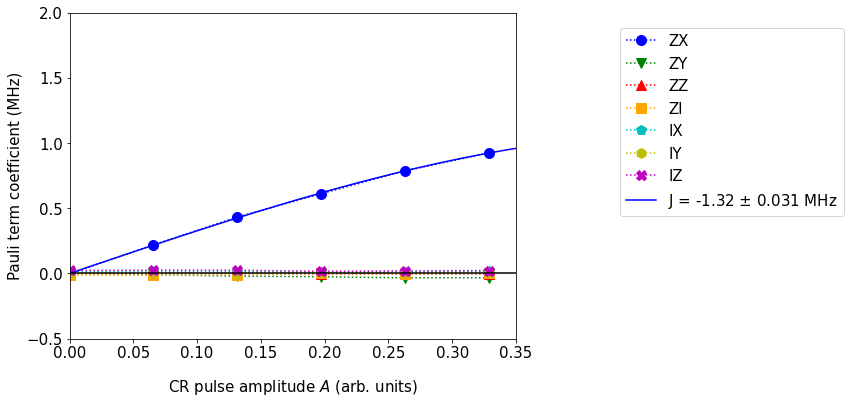

In [48]:
x_interp = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

for pauli_label, color, marker in zip(pauli_labels, colors, markers):
    ax1.plot(pulse_avg_amplitude, cr2_ham[pauli_label]/2/np.pi/1e6,
             '%s:' % marker, ms=10, color=color, label=pauli_label)

# fit models
ax1.plot(x_interp, fitters['ZX'](x_interp, *cr2_params)/2/np.pi/1e6,
         color='b', label='J = %.2f $\pm$ %.3f MHz' % (cr2_params[0] / 2 / np.pi / 1e6, stdev))

ax1.plot([0, 1], [0, 0], 'k-')
ax1.set_xlabel(r'CR pulse amplitude $A$ (arb. units)', fontsize=15)
ax1.set_ylabel(r'Pauli term coefficient (MHz)', fontsize=15)
ax1.set_xlim(0, max_cr_amplitude)
ax1.set_ylim(-0.5, 2)
ax1.tick_params(labelsize=15)

ax1.xaxis.set_label_coords(0.5, -0.12)

ax1.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=1, fontsize=15)

# 5. Local fidelity optimization

Setup

In [49]:
shots = 2048

In [50]:
def cr_amp_objective(x, params, gate_time):
    x_avg = average_amp(x)
    return np.abs(0.5 * np.pi - fitters['ZX'](x_avg, *params) * gate_time)

In [51]:
control_logical_ind, target_logical_ind = (1, 0) if control > target else (0, 1)

In [52]:
# create reference quantum channel of CNOT.
# after measuring Choi matrix at the optimal CR pulse amplitude,
# we can optimize pre and post local rotations so that measured Choi matrix becomes CNOT.

ref_cnot_f = qiskit.QuantumCircuit(2)
ref_cnot_f.cx(control_logical_ind, target_logical_ind)
ref_cnot_f_oper = qi.Operator(ref_cnot_f)

ref_cnot_b = qiskit.QuantumCircuit(2)
ref_cnot_b.cx(target_logical_ind, control_logical_ind)
ref_cnot_b_oper = qi.Operator(ref_cnot_b)

## 5-1. Measure QPTs at optimal amplitude

In [53]:
# find optimal CR amp from the ZX fit: CR1
cr1_amp_opt = opt.dual_annealing(cr_amp_objective, x0=[0], bounds=[(0, 0.35)], args=(cr1_params, cr1_gate_time))
cr1_circ_zx90 = cr1_circ.bind_parameters({var_amp: cr1_amp_opt.x[0]})

cr1_circ_zx90.draw(fold=-1, idle_wires=False)

┌──────────────────────────┐
 q0_8: ┤1                         ├
       │  zx_p(0.350000000000000) │
q0_11: ┤0                         ├
       └──────────────────────────┘

In [54]:
# find optimal CR amp from the ZX fit: CR2
cr2_amp_opt = opt.dual_annealing(cr_amp_objective, x0=[0], bounds=[(0, 0.35)], args=(cr2_params, cr2_gate_time))
cr2_circ_zx90 = cr2_circ.bind_parameters({var_amp: cr2_amp_opt.x[0]})

cr2_circ_zx90.draw(fold=-1, idle_wires=False)

┌──────────────────────────┐     ┌──────────────────────────┐     
 q0_8: ┤1                         ├─────┤1                         ├─────
       │  zx_p(0.198046472656445) │┌───┐│  zx_m(0.198046472656445) │┌───┐
q0_11: ┤0                         ├┤ X ├┤0                         ├┤ X ├
       └──────────────────────────┘└───┘└──────────────────────────┘└───┘

In [55]:
# create QPT schedule
cr1_sched_opt, qcs1, meas_labels = create_qpt_experiment(
    target_circuits=cr1_circ_zx90,
    control=control,
    target=target,
    backend=backend,
    mit_readout=True,
    inst_map=ext_inst_map_cr1,
    basis_gate=ext_basis_gates_cr1,
    shots=shots, 
    return_schedule=True
)

cr2_sched_opt, qcs2, _ = create_qpt_experiment(
    target_circuits=cr2_circ_zx90,
    control=control,
    target=target,
    backend=backend,
    mit_readout=False,
    inst_map=ext_inst_map_cr2,
    basis_gate=ext_basis_gates_cr2,
    shots=shots, 
    return_schedule=True
)

# combine two QPT experiments and readout error mitigation experiments
bind_scheds = align_measures(cr1_sched_opt + cr2_sched_opt, max_calibration_duration=0)
bind_qcs = qcs1 + qcs2

qobj_5_1 = qiskit.assemble(bind_scheds, backend=backend, meas_level=2, shots=shots)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [56]:
# run experiment
result_5_1 = runner.run(qobj_5_1, '5-1_qpt_zx90')

Analysis

In [57]:
cr1_choi_opt, cr2_choi_opt = [choi for choi in extract_choi_matrix(result_5_1, bind_qcs, meas_labels)]

if not use_cache:
    # output data for future analysis.
    np.save('%s/5-1_zx90_choi_mat.npy' % data_dir, [cr1_choi_opt.data, cr2_choi_opt.data])

readout fidelity = 0.978


## 5-2. Local fidelity optimization
Note that there are multiple optimal U3 sets and retult may change for each execution.

In [58]:
# optimize local U3 rotations to realize CNOT: CR1 forward order (control, target)
if use_cache:
    with open('%s/cr1_cnot_f_params.npy' % data_dir, 'rb') as fp:
        cr1_cnot_f_params = np.load(fp)
else:
    cr1_cnot_f_params = local_fidelity_optimization(cr1_choi_opt, ref_cnot_f_oper)
    np.save('%s/cr1_cnot_f_params.npy' % data_dir, cr1_cnot_f_params)

cr1_cnot_f = optimize_circuit(cr1_circ_zx90, control, target, cr1_cnot_f_params)
cr1_cnot_f.draw(fold=-1, idle_wires=False)

Original F_avg: 0.30054
Optimized F_avg: 0.97021


┌────────────────────────────┐ ┌──────────────────────────┐  ┌────────────────────────────┐  
 q0_8: ─┤ U3(1.8492,-1.6468,-1.5857) ├─┤1                         ├──┤ U3(-3.139,-1.8135,-1.7987) ├──
       ┌┴────────────────────────────┴┐│  zx_p(0.350000000000000) │┌─┴────────────────────────────┴─┐
q0_11: ┤ U3(-0.033967,0.57489,2.8897) ├┤0                         ├┤ U3(0.0097181,-2.0692,-0.50433) ├
       └──────────────────────────────┘└──────────────────────────┘└────────────────────────────────┘

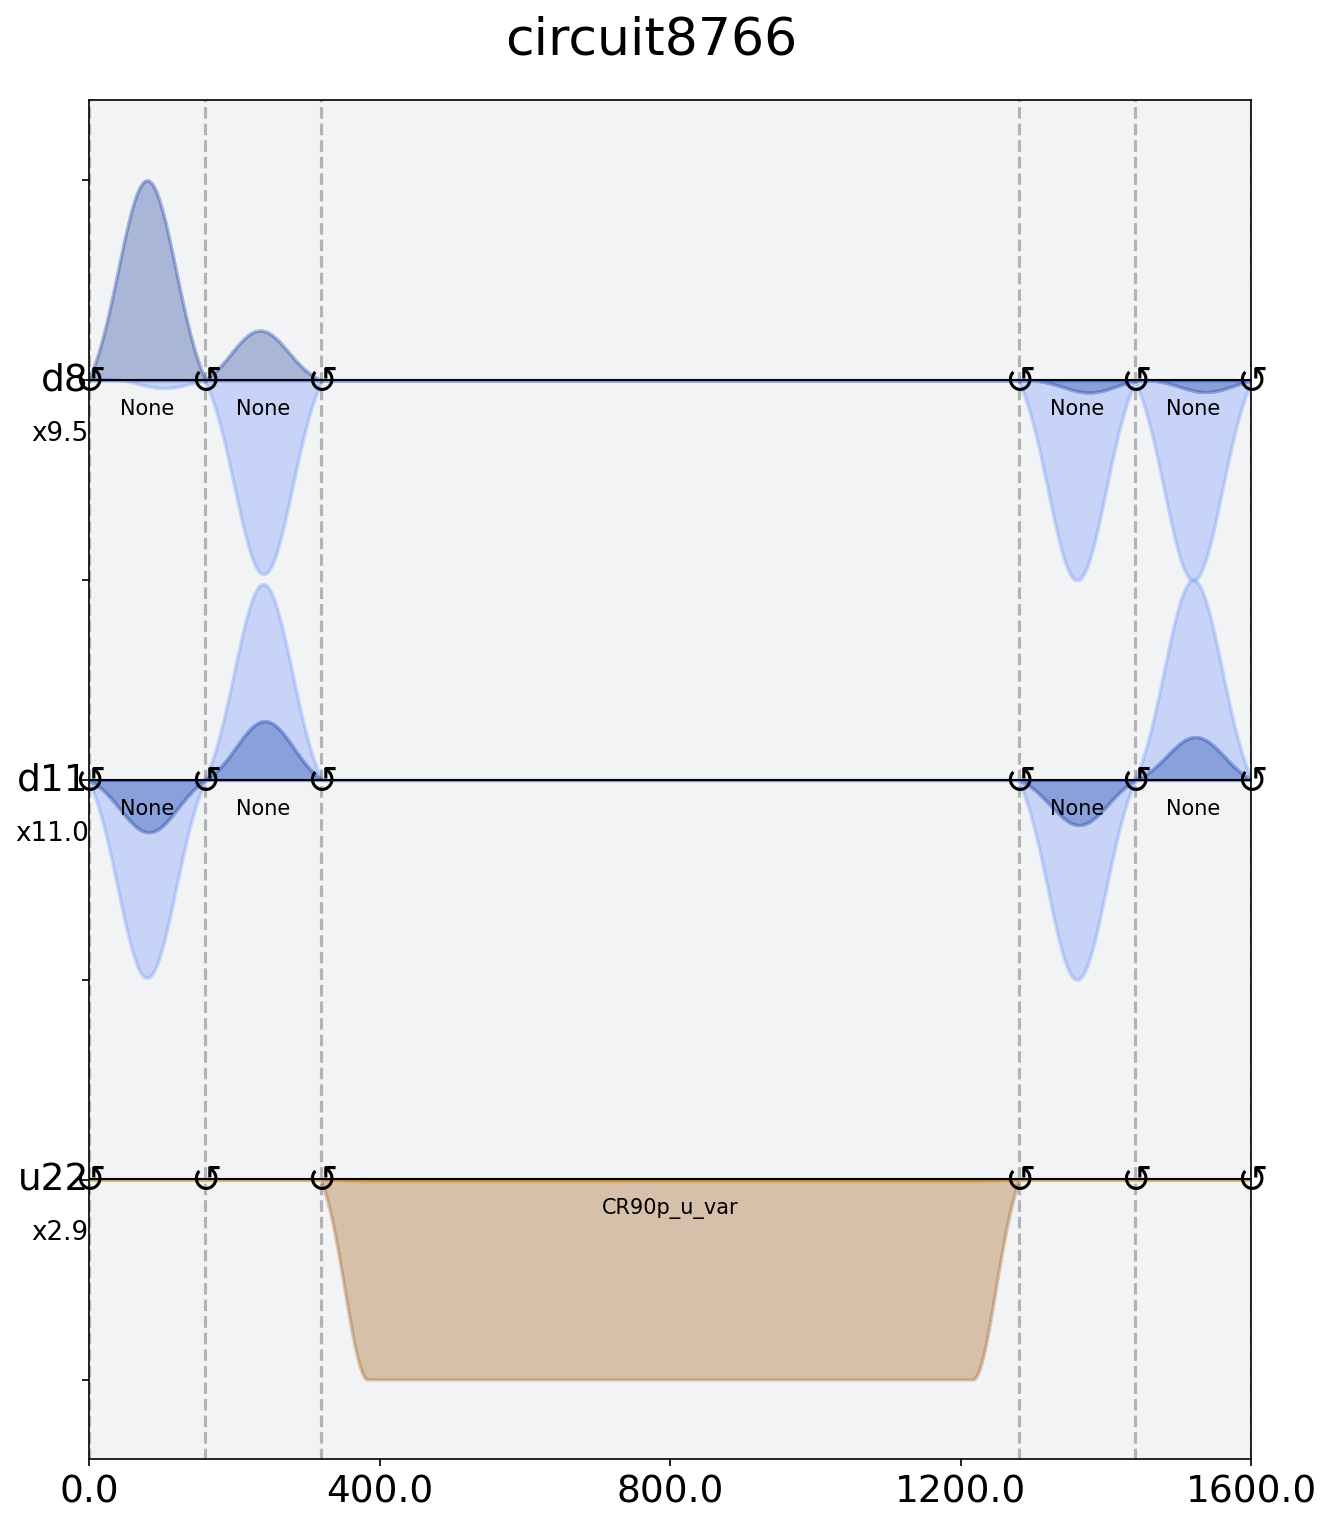

In [59]:
cr1_cnot_f_sched = schedule(cr1_cnot_f, backend, inst_map=ext_inst_map_cr1)
if not use_cache:
    with open('%s/sched_cr1_cnot_f.pk' % data_dir, 'wb') as fp:
        pickle.dump(cr1_cnot_f_sched, fp)
        
cr1_cnot_f_sched.draw(channels=channels, table=False, label=True)

In [60]:
# optimize local U3 rotations to realize CNOT: CR1 reverse order (control, target)
if use_cache:
    with open('%s/cr1_cnot_b_params.npy' % data_dir, 'rb') as fp:
        cr1_cnot_b_params = np.load(fp)
else:
    cr1_cnot_b_params = local_fidelity_optimization(cr1_choi_opt, ref_cnot_b_oper)
    np.save('%s/cr1_cnot_b_params.npy' % data_dir, cr1_cnot_b_params)

cr1_cnot_b = optimize_circuit(cr1_circ_zx90, control, target, cr1_cnot_b_params)
cr1_cnot_b.draw(fold=-1, idle_wires=False)

Original F_avg: 0.31356
Optimized F_avg: 0.97022


┌───────────────────────────┐ ┌──────────────────────────┐┌─────────────────────────────┐
 q0_8: ┤ U3(1.5565,3.0697,0.71919) ├─┤1                         ├┤ U3(1.5703,0.57579,0.014779) ├
       ├───────────────────────────┴┐│  zx_p(0.350000000000000) │└─┬──────────────────────────┬┘
q0_11: ┤ U3(-1.5791,1.9044,-3.1081) ├┤0                         ├──┤ U3(1.5816,3.141,-1.0132) ├─
       └────────────────────────────┘└──────────────────────────┘  └──────────────────────────┘

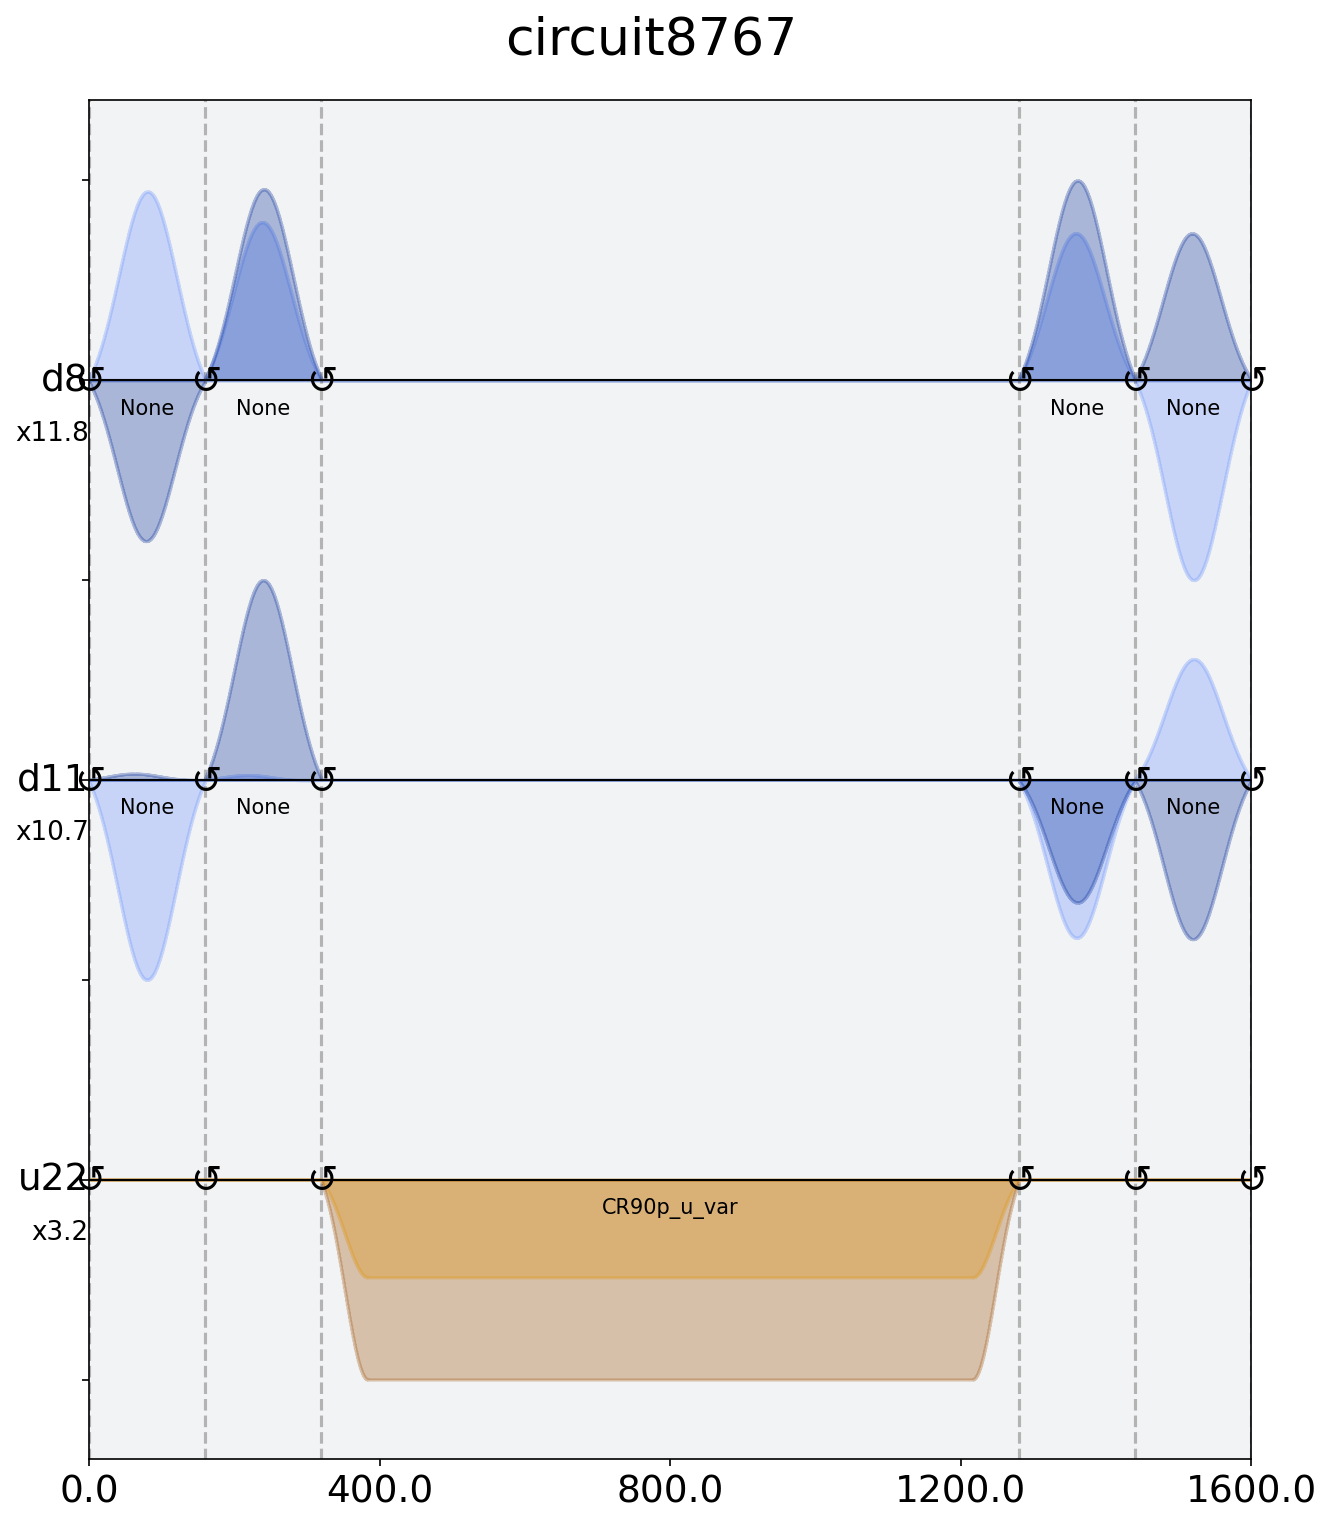

In [61]:
cr1_cnot_b_sched = schedule(cr1_cnot_b, backend, inst_map=ext_inst_map_cr1)
if not use_cache:
    with open('%s/sched_cr1_cnot_b.pk' % data_dir, 'wb') as fp:
        pickle.dump(cr1_cnot_b_sched, fp)
        
cr1_cnot_b_sched.draw(channels=channels, table=False, label=True)

In [62]:
# optimize local U3 rotations to realize CNOT: CR2 forward order(control, target)
if use_cache:
    with open('%s/cr2_cnot_f_params.npy' % data_dir, 'rb') as fp:
        cr2_cnot_f_params = np.load(fp)
else:
    cr2_cnot_f_params = local_fidelity_optimization(cr2_choi_opt, ref_cnot_f_oper)
    np.save('%s/cr2_cnot_f_params.npy' % data_dir, cr2_cnot_f_params)

cr2_cnot_f = optimize_circuit(cr2_circ_zx90, control, target, cr2_cnot_f_params)
cr2_cnot_f.draw(fold=-1, idle_wires=False)

Original F_avg: 0.39612
Optimized F_avg: 0.99237


┌──────────────────────────┐┌──────────────────────────┐     ┌──────────────────────────┐┌───────────────────────────┐                              
 q0_8: ─┤ U3(2.1345,1.487,-1.5701) ├┤1                         ├─────┤1                         ├┤ U3(2.6066,1.5865,-1.5536) ├──────────────────────────────
       ┌┴──────────────────────────┤│  zx_p(0.198046472656445) │┌───┐│  zx_m(0.198046472656445) │└───────────┬───┬───────────┘┌────────────────────────────┐
q0_11: ┤ U3(3.116,0.95666,-1.6434) ├┤0                         ├┤ X ├┤0                         ├────────────┤ X ├────────────┤ U3(-3.1249,3.0382,-1.1138) ├
       └───────────────────────────┘└──────────────────────────┘└───┘└──────────────────────────┘            └───┘            └────────────────────────────┘

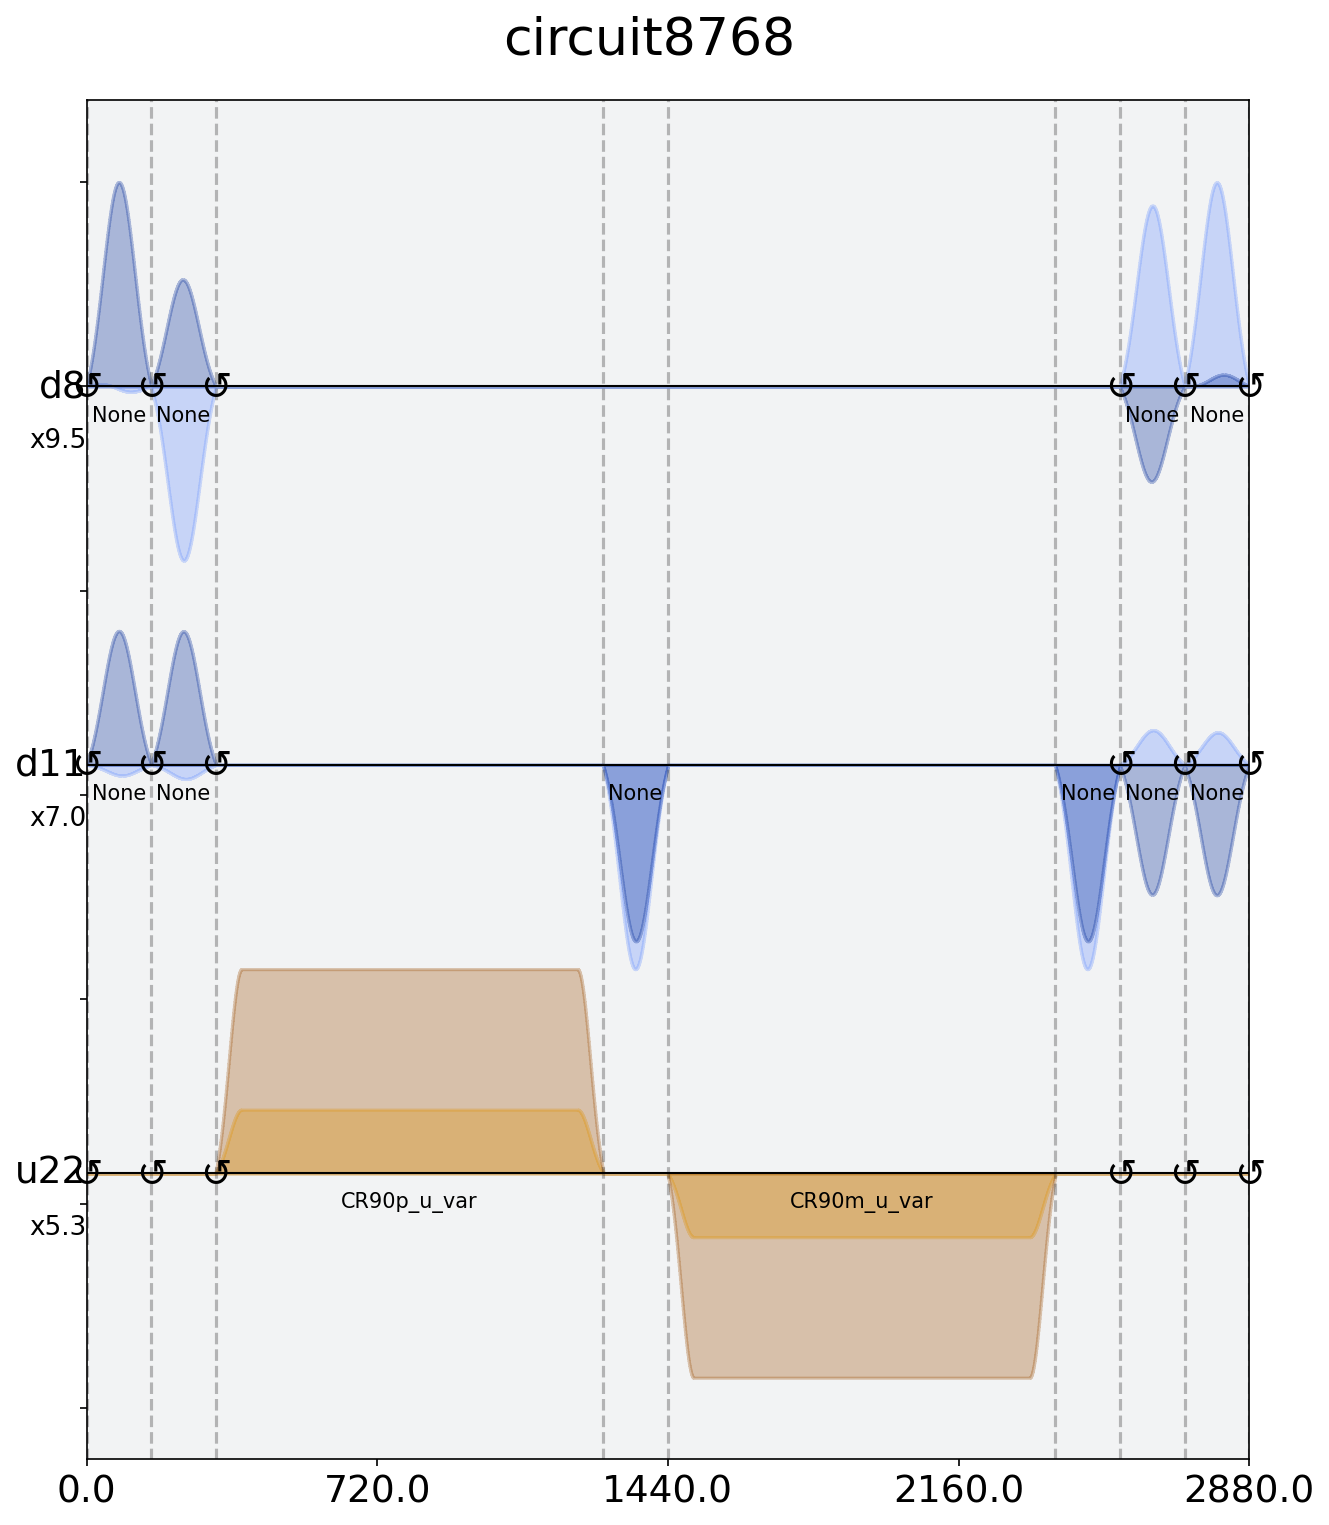

In [63]:
cr2_cnot_f_sched = schedule(cr2_cnot_f, backend, inst_map=ext_inst_map_cr2)
if not use_cache:
    with open('%s/sched_cr2_cnot_f.pk' % data_dir, 'wb') as fp:
        pickle.dump(cr2_cnot_f_sched, fp)
        
cr2_cnot_f_sched.draw(channels=channels, table=False, label=True)

In [64]:
# optimize local U3 rotations to realize CNOT: CR2 reverse order(target, control)
if use_cache:
    with open('%s/cr2_cnot_b_params.npy' % data_dir, 'rb') as fp:
        cr2_cnot_b_params = np.load(fp)
else:
    cr2_cnot_b_params = local_fidelity_optimization(cr2_choi_opt, ref_cnot_b_oper)
    np.save('%s/cr2_cnot_b_params.npy' % data_dir, cr2_cnot_b_params)
    
cr2_cnot_b = optimize_circuit(cr2_circ_zx90, control, target, cr2_cnot_b_params)
cr2_cnot_b.draw(fold=-1, idle_wires=False)

Original F_avg: 0.29929
Optimized F_avg: 0.99237


┌───────────────────────────┐ ┌──────────────────────────┐     ┌──────────────────────────┐┌────────────────────────────┐                                
 q0_8: ─┤ U3(1.5702,3.0574,-3.0634) ├─┤1                         ├─────┤1                         ├┤ U3(-1.5628,1.5213,-3.1379) ├────────────────────────────────
       ┌┴───────────────────────────┴┐│  zx_p(0.198046472656445) │┌───┐│  zx_m(0.198046472656445) │└───────────┬───┬────────────┘┌──────────────────────────────┐
q0_11: ┤ U3(1.5915,-1.5529,0.015131) ├┤0                         ├┤ X ├┤0                         ├────────────┤ X ├─────────────┤ U3(-1.5781,0.014968,-3.1404) ├
       └─────────────────────────────┘└──────────────────────────┘└───┘└──────────────────────────┘            └───┘             └──────────────────────────────┘

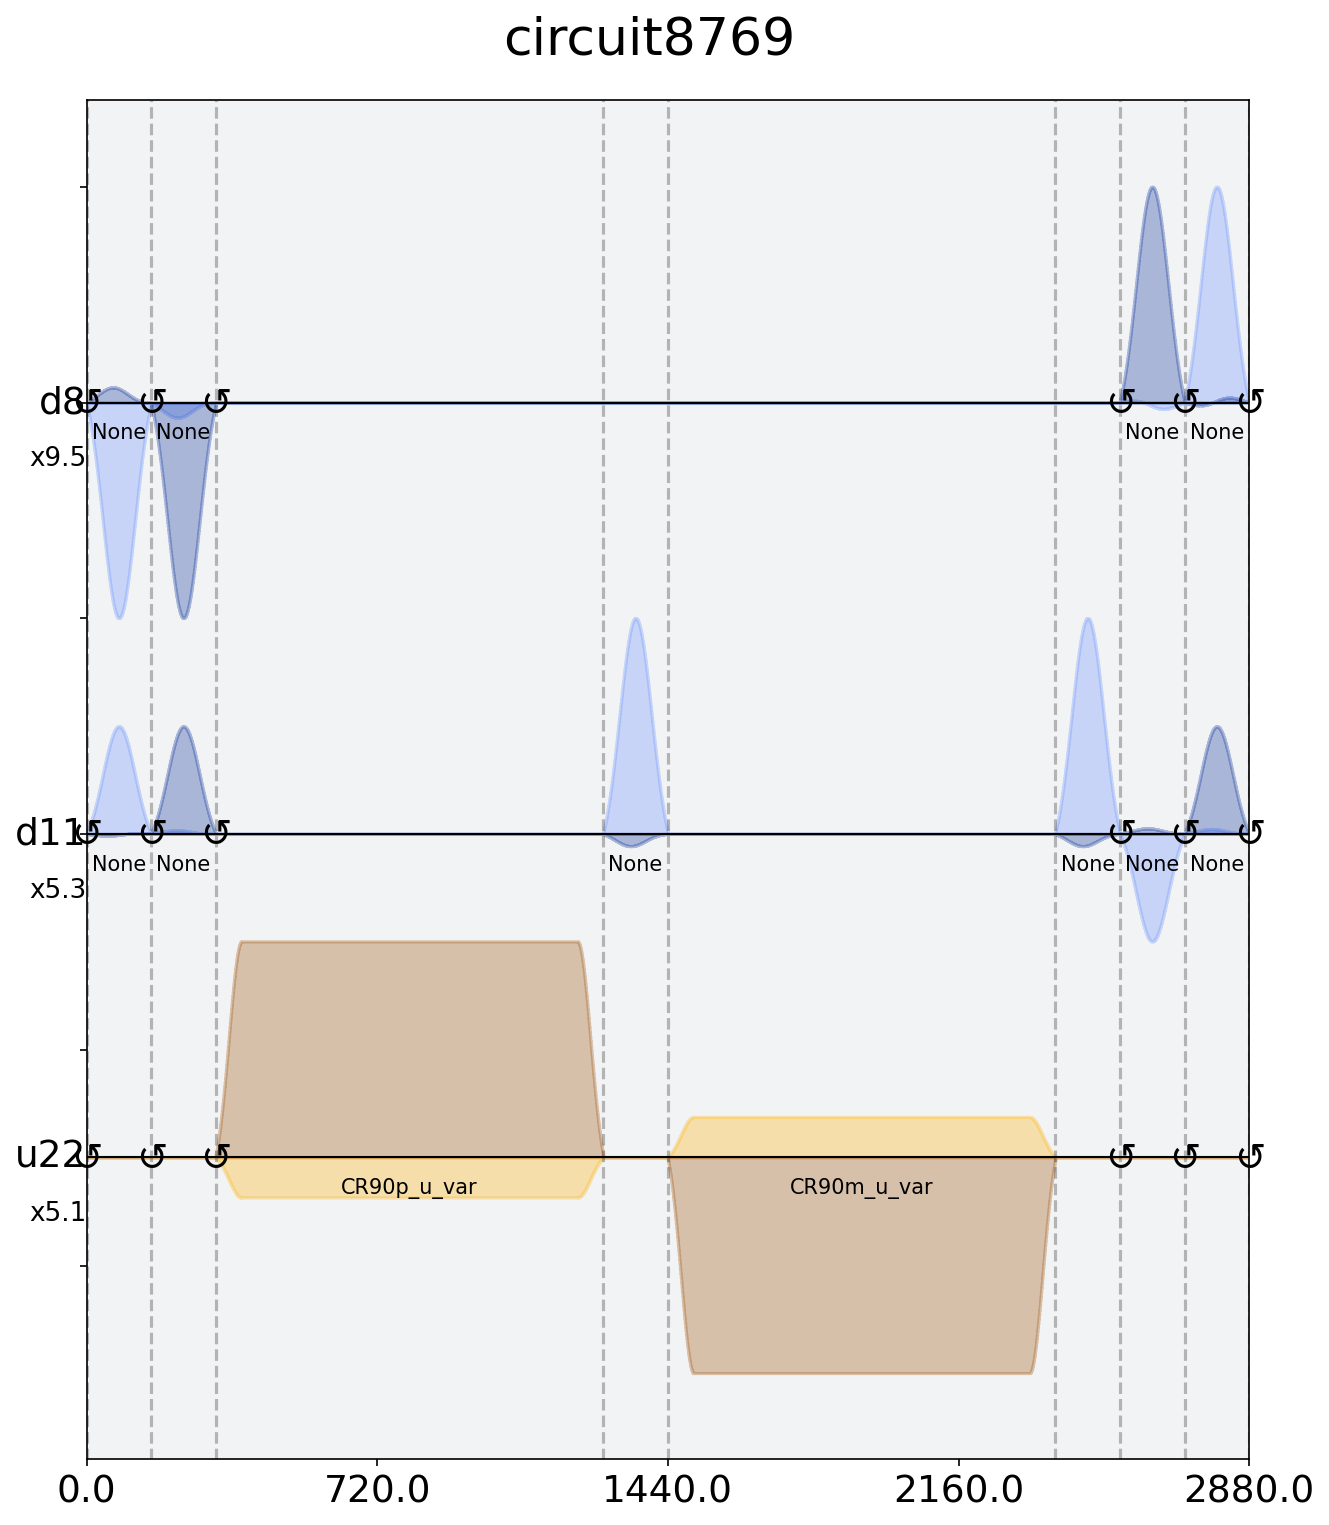

In [65]:
cr2_cnot_b_sched = schedule(cr2_cnot_b, backend, inst_map=ext_inst_map_cr2)
if not use_cache:
    with open('%s/sched_cr2_cnot_b.pk' % data_dir, 'wb') as fp:
        pickle.dump(cr2_cnot_b_sched, fp)
        
cr2_cnot_b_sched.draw(channels=channels, table=False, label=True)

In [66]:
qubit_layout = {ref_cnot_f.qregs[0][control_logical_ind]: control, ref_cnot_f.qregs[0][target_logical_ind]: target}

routed_ref_cnot_f = transpile(ref_cnot_f, backend, initial_layout=qubit_layout, optimization_level=0)
routed_ref_cnot_b = transpile(ref_cnot_b, backend, initial_layout=qubit_layout, optimization_level=0)

In [67]:
# create QPT schedules to evaluate fidelity of optimized schedules
cr1_cnot_qpt, qcs1, meas_labels = create_qpt_experiment(
    target_circuits=[cr1_cnot_f, cr1_cnot_b],
    control=control,
    target=target,
    backend=backend,
    mit_readout=True,
    inst_map=ext_inst_map_cr1,
    basis_gate=ext_basis_gates_cr1,
    shots=shots, 
    return_schedule=True
)

cr2_cnot_qpt, qcs2, _ = create_qpt_experiment(
    target_circuits=[cr2_cnot_f, cr2_cnot_b],
    control=control,
    target=target,
    backend=backend,
    mit_readout=False,
    inst_map=ext_inst_map_cr2,
    basis_gate=ext_basis_gates_cr2,
    shots=shots, 
    return_schedule=True
)

backend_cnot_qpt, qcs3, _ = create_qpt_experiment(
    target_circuits=[routed_ref_cnot_f, routed_ref_cnot_b],
    control=control,
    target=target,
    backend=backend,
    mit_readout=False,
    inst_map=ext_inst_map_cr2,
    basis_gate=ext_basis_gates_cr2,
    shots=shots, 
    return_schedule=True
)

# combine two QPT experiments and readout error mitigation experiments
bind_scheds = align_measures(cr1_cnot_qpt + cr2_cnot_qpt + backend_cnot_qpt, max_calibration_duration=0)
bind_qcs = qcs1 + qcs2 + qcs3

qobj_5_2 = qiskit.assemble(bind_scheds, backend=backend, meas_level=2, shots=shots)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [68]:
# run experiment
result_5_2 = runner.run(qobj_5_2, '5-2_qpt_cnot')

Analysis

In [69]:
choi_mats = [choi for choi in extract_choi_matrix(result_5_2, bind_qcs, meas_labels)]

if not use_cache:
    # output data for future analysis.
    np.save('%s/5-2_cnot_choi_mat.npy' % data_dir, [choi_mat.data for choi_mat in choi_mats])

readout fidelity = 0.973


In [70]:
print('CR1-CNOT (control, target) F_avg = %f' % qi.average_gate_fidelity(choi_mats[0],
                                                                         ref_cnot_f,
                                                                         require_cp=False))
print('CR1-CNOT (target, control) F_avg = %f' % qi.average_gate_fidelity(choi_mats[1],
                                                                         ref_cnot_b,
                                                                         require_cp=False))

print('CR2-CNOT (control, target) F_avg = %f' % qi.average_gate_fidelity(choi_mats[2],
                                                                         ref_cnot_f,
                                                                         require_cp=False))
print('CR2-CNOT (target, control) F_avg = %f' % qi.average_gate_fidelity(choi_mats[3],
                                                                         ref_cnot_b,
                                                                         require_cp=False))

print('Backend CNOT (control, target) F_avg = %f' % qi.average_gate_fidelity(choi_mats[4],
                                                                             ref_cnot_f,
                                                                             require_cp=False))
print('Backend CNOT (target, control) F_avg = %f' % qi.average_gate_fidelity(choi_mats[5],
                                                                             ref_cnot_b,
                                                                             require_cp=False))

CR1-CNOT (control, target) F_avg = 0.971776
CR1-CNOT (target, control) F_avg = 0.974954
CR2-CNOT (control, target) F_avg = 0.994006
CR2-CNOT (target, control) F_avg = 0.993730
Backend CNOT (control, target) F_avg = 0.996232
Backend CNOT (target, control) F_avg = 0.996166


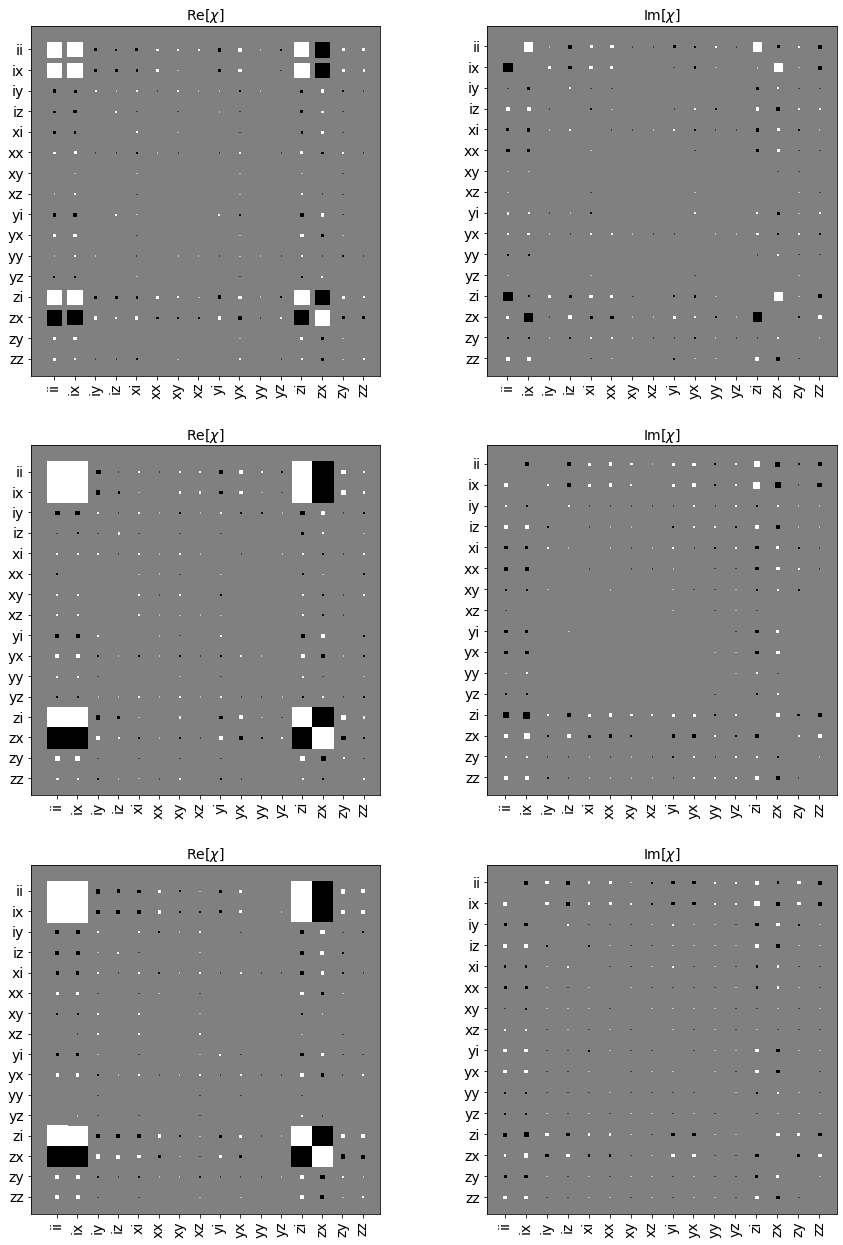

In [71]:
# Chi matrix of CNOT (control, target), from the top: CR1, CR2, Backend
n_exp = 3
plt.figure(figsize=(15, 15 * n_exp))
axs_r = [plt.subplot(2*n_exp, 2, 1 + 2*ii) for ii in range(n_exp)]
axs_i = [plt.subplot(2*n_exp, 2, 2 + 2*ii) for ii in range(n_exp)]
plot_quantum_channel([choi_mats[0], choi_mats[2], choi_mats[4]], axs_r, axs_i)
plt.show()

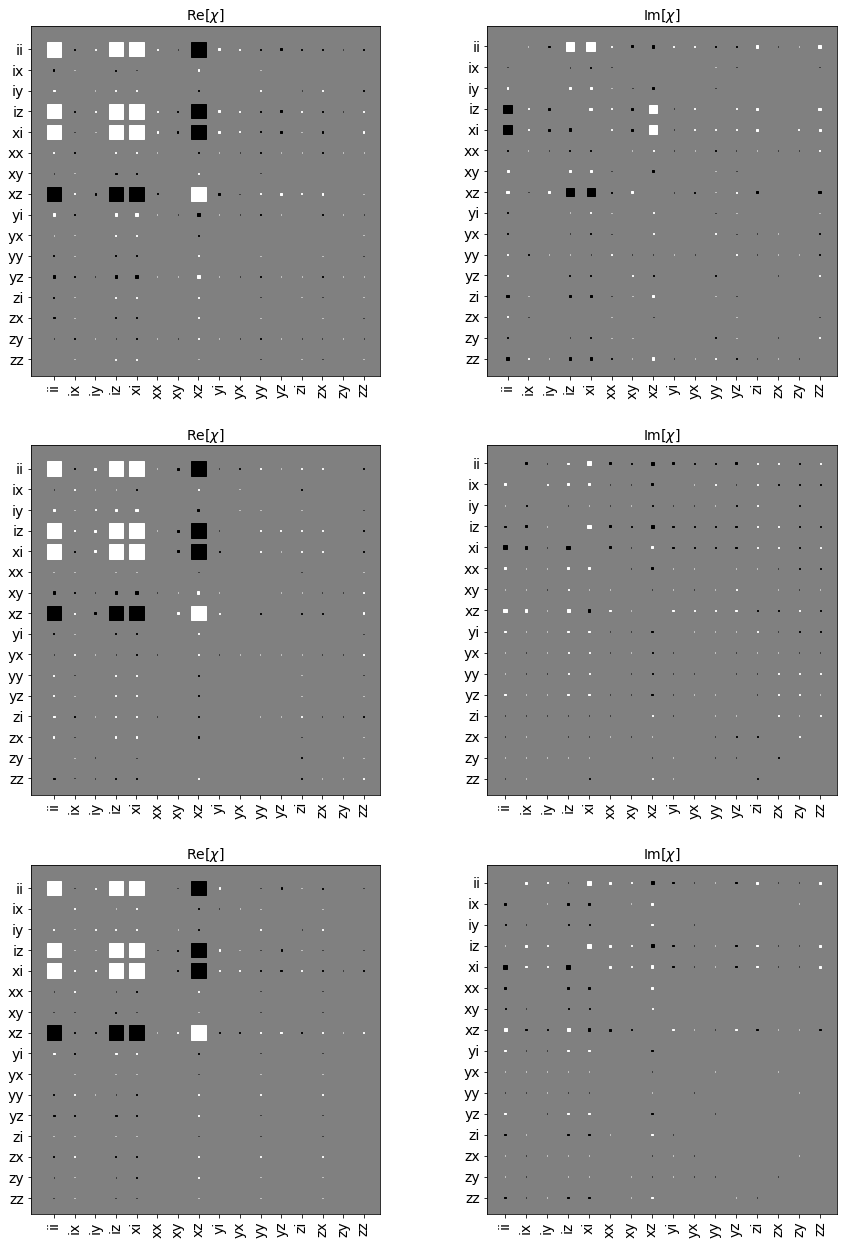

In [72]:
# Chi matrix of CNOT (target, control), from the top: CR1, CR2, Backend
n_exp = 3
plt.figure(figsize=(15, 15 * n_exp))
axs_r = [plt.subplot(2*n_exp, 2, 1 + 2*ii) for ii in range(n_exp)]
axs_i = [plt.subplot(2*n_exp, 2, 2 + 2*ii) for ii in range(n_exp)]
plot_quantum_channel([choi_mats[1], choi_mats[3], choi_mats[5]], axs_r, axs_i)
plt.show()

# 6. RB fidelity

Setup

In [73]:
shots = 1024

n_seeds = 5
n_cliffs = np.arange(1, 200, 20)

In [74]:
# create 1Q RB sequences
rb_patterns_1q = [[cr_qubits[0]], [cr_qubits[1]]]
xdata_1q = np.array([n_cliffs, n_cliffs])

rb_1q_circs_seeds, _ = rb.randomized_benchmarking_seq(length_vector=n_cliffs,
                                                      nseeds=n_seeds,
                                                      rb_pattern=rb_patterns_1q,
                                                      rand_seed=31)

In [75]:
# create 2Q RB sequences
rb_patterns_2q = [[cr_qubits[0], cr_qubits[1]]]
xdata_2q = np.array([n_cliffs])

rb_2q_circs_seeds, _ = rb.randomized_benchmarking_seq(length_vector=n_cliffs,
                                                      nseeds=n_seeds,
                                                      rb_pattern=rb_patterns_2q,
                                                      rand_seed=31)

## 6-1. Single qubit RB to investigate EPGs of single qubit basis gates

In [76]:
qobj_6_1, rb_transpiled_circus = create_rb_experiment(
    rb_seed_circs=rb_1q_circs_seeds,
    control=control,
    target=target,
    backend=backend,
    shots=shots
)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [77]:
# run experiment
result_6_1 = runner.run(qobj_6_1, '6-1_rb_1q')

Analysis

In [78]:
rb_1q_fit = rb.fitters.RBFitter(result_6_1, cliff_lengths=xdata_1q, rb_pattern=rb_patterns_1q)

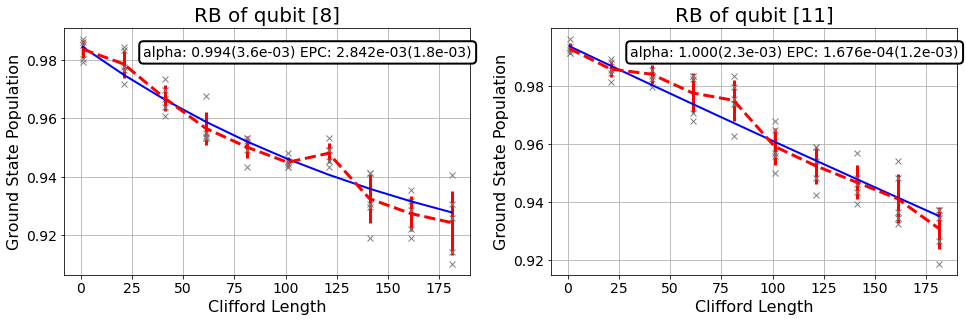

In [79]:
plt.figure(figsize=(16, 10))

for ii in range(len(rb_patterns_1q)):
    ax = plt.subplot(len(rb_patterns_1q), 2, ii+1)
    rb_1q_fit.plot_rb_data(pattern_index=ii, ax=ax, show_plt=False)
    ax.set_title('RB of qubit %s' % rb_patterns_1q[ii], fontsize=20)

plt.show()

In [80]:
# count gate per Clifford
gpc = rb.gates_per_clifford(
    transpiled_circuits_list=rb_transpiled_circus,
    clifford_lengths=n_cliffs,
    basis=['u1', 'u2', 'u3', 'cx'],
    qubits=cr_qubits
)
gpc

{8: {'u1': 1.0813043478260869,
  'u2': 0.663695652173913,
  'u3': 0.5228260869565218,
  'cx': 0.0},
 11: {'u1': 1.0767391304347826,
  'u2': 0.6582608695652173,
  'u3': 0.5232608695652174,
  'cx': 0.0}}

In [81]:
# calculate 1Q EPGs
epg_q0 = rb.calculate_1q_epg(
    gate_per_cliff=gpc,
    epc_1q=rb_1q_fit.fit[0]['epc'],
    qubit=rb_patterns_1q[0][0]
)
epg_q1 = rb.calculate_1q_epg(
    gate_per_cliff=gpc,
    epc_1q=rb_1q_fit.fit[1]['epc'],
    qubit=rb_patterns_1q[1][0]
)

for qid, epg in enumerate([epg_q0, epg_q1]):
    for basis, val in epg.items():
        print('[Q%d] %s: %.3e' % (rb_patterns_1q[qid][0], basis, val))

[Q8] u1: 0.000e+00
[Q8] u2: 1.663e-03
[Q8] u3: 3.326e-03
[Q11] u1: 0.000e+00
[Q11] u2: 9.834e-05
[Q11] u3: 1.967e-04


## 6-2. Two qubit RB with CR1 CNOT

In [82]:
qobj_6_2, rb_transpiled_circus = create_rb_experiment(
    rb_seed_circs=rb_2q_circs_seeds,
    control=control,
    target=target,
    backend=backend,
    cnot_sched_control_target=cr1_cnot_f_sched,
    cnot_sched_target_control=cr1_cnot_b_sched,
    shots=shots
)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [83]:
# run experiment
result_6_2 = runner.run(qobj_6_2, '6-2_rb_2q_cr1')

Analysis

In [84]:
rb_2q_cr1_fit = rb.fitters.RBFitter(result_6_2, cliff_lengths=xdata_2q, rb_pattern=rb_patterns_2q)

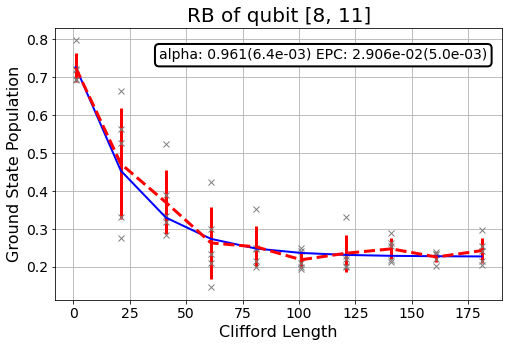

In [85]:
plt.figure(figsize=(8, 5))

ax = plt.subplot(111)
rb_2q_cr1_fit.plot_rb_data(pattern_index=0, ax=ax, show_plt=False)
ax.set_title('RB of qubit %s' % rb_patterns_2q[0], fontsize=20)

plt.show()

In [86]:
# count gate per Clifford
gpc = rb.gates_per_clifford(
    transpiled_circuits_list=rb_transpiled_circus,
    clifford_lengths=n_cliffs,
    basis=['u1', 'u2', 'u3', 'cx'],
    qubits=cr_qubits
)
gpc

{8: {'u1': 2.077391304347826,
  'u2': 1.6752173913043478,
  'u3': 0.4810869565217391,
  'cx': 1.4960869565217392},
 11: {'u1': 2.0380434782608696,
  'u2': 1.6504347826086956,
  'u3': 0.532608695652174,
  'cx': 1.4960869565217392}}

In [87]:
# calculate 2Q EPG
epgs_2q_cr1 = rb.calculate_2q_epg(
    gate_per_cliff=gpc,
    epc_2q=rb_2q_cr1_fit.fit[0]['epc'],
    qubit_pair=cr_qubits,
    list_epgs_1q=[epg_q0, epg_q1]
)
1 - epgs_2q_cr1

0.9841790433847533

## 6-3. Two qubit RB with CR2 CNOT

In [88]:
qobj_6_3, rb_transpiled_circus = create_rb_experiment(
    rb_seed_circs=rb_2q_circs_seeds,
    control=control,
    target=target,
    backend=backend,
    cnot_sched_control_target=cr2_cnot_f_sched,
    cnot_sched_target_control=cr2_cnot_b_sched,
    shots=shots
)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [89]:
# run experiment
result_6_3 = runner.run(qobj_6_3, '6-3_rb_2q_cr2')

Analysis

In [90]:
rb_2q_cr2_fit = rb.fitters.RBFitter(result_6_3, cliff_lengths=xdata_2q, rb_pattern=rb_patterns_2q)

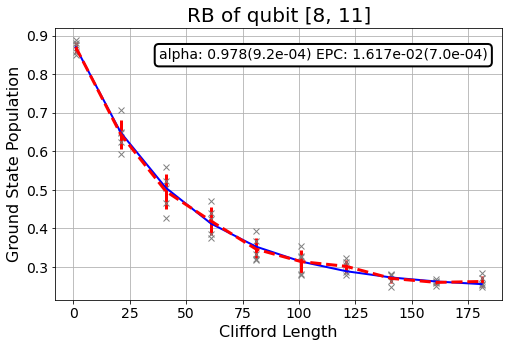

In [91]:
plt.figure(figsize=(8, 5))

ax = plt.subplot(111)
rb_2q_cr2_fit.plot_rb_data(pattern_index=0, ax=ax, show_plt=False)
ax.set_title('RB of qubit %s' % rb_patterns_2q[0], fontsize=20)

plt.show()

In [92]:
# calculate 2Q EPG
epgs_2q_cr2 = rb.calculate_2q_epg(
    gate_per_cliff=gpc,
    epc_2q=rb_2q_cr2_fit.fit[0]['epc'],
    qubit_pair=cr_qubits,
    list_epgs_1q=[epg_q0, epg_q1]
)
1 - epgs_2q_cr2

0.9928622266256778

## 6-4. Two qubit RB with backend CNOT

In [93]:
qobj_6_4, rb_transpiled_circus = create_rb_experiment(
    rb_seed_circs=rb_2q_circs_seeds,
    control=control,
    target=target,
    backend=backend,
    shots=shots
)

/home/knzwnao/venv/qiskit/lib/python3.7/site-packages/qiskit/compiler/assemble.py:305: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


In [94]:
# run experiment
result_6_4 = runner.run(qobj_6_4, '6-4_rb_2q_back')

Analysis

In [95]:
rb_2q_back_fit = rb.fitters.RBFitter(result_6_4, cliff_lengths=xdata_2q, rb_pattern=rb_patterns_2q)

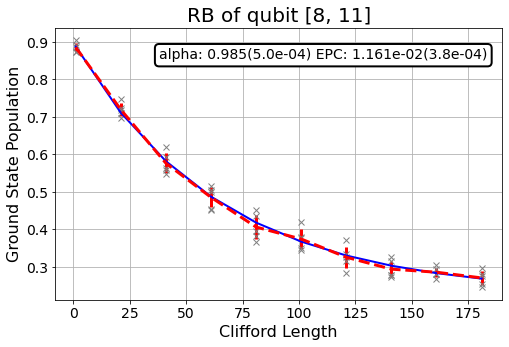

In [96]:
plt.figure(figsize=(8, 5))

ax = plt.subplot(111)
rb_2q_back_fit.plot_rb_data(pattern_index=0, ax=ax, show_plt=False)
ax.set_title('RB of qubit %s' % rb_patterns_2q[0], fontsize=20)

plt.show()

In [97]:
# calculate 2Q EPG
epgs_2q_back = rb.calculate_2q_epg(
    gate_per_cliff=gpc,
    epc_2q=rb_2q_back_fit.fit[0]['epc'],
    qubit_pair=cr_qubits,
    list_epgs_1q=[epg_q0, epg_q1]
)
1 - epgs_2q_back

0.9959343495450343

# 7. Fidelity Upperbounds

In [98]:
t1s = [experiment_conditions['target_qubit_t1'], experiment_conditions['control_qubit_t1']]
t2s = [experiment_conditions['target_qubit_t2'], experiment_conditions['control_qubit_t2']]

cr1_cnot_dur = cr1_cnot_f_sched.duration * config.dt
cr2_cnot_dur = cr2_cnot_f_sched.duration * config.dt
back_cnot_dur = experiment_conditions['backend_cnot_gate_length']

print('CR1 CNOT fidelity upper bound %.3e' % (1 - rb.coherence_limit(nQ=2, T1_list=t1s, T2_list=t2s, gatelen=cr1_cnot_dur)))
print('CR2 CNOT fidelity upper bound %.3e' % (1 - rb.coherence_limit(nQ=2, T1_list=t1s, T2_list=t2s, gatelen=cr2_cnot_dur)))
print('Backend CNOT fidelity upper bound %.3e' % (1 - rb.coherence_limit(nQ=2, T1_list=t1s, T2_list=t2s, gatelen=back_cnot_dur)))

CR1 CNOT fidelity upper bound 9.943e-01
CR2 CNOT fidelity upper bound 9.898e-01
Backend CNOT fidelity upper bound 9.928e-01


In [99]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright